In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
from tqdm.notebook import tqdm
import os
from ast import literal_eval
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,Lambda
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import re
from __future__ import absolute_import, division, print_function, unicode_literals

# 1.Data Preparation

# Load news articles and categories.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d shivamkushwaha/bbc-full-text-document-classification
!unzip bbc-full-text-document-classification.zip

Dataset URL: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification
License(s): DbCL-1.0
bbc-full-text-document-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bbc-full-text-document-classification.zip
replace bbc-fulltext (document classification)/bbc/README.TXT? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: bbc-fulltext (document classification)/bbc/README.TXT  
  inflating: bbc-fulltext (document classification)/bbc/business/001.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/002.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/003.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/004.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/005.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/006.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/007.txt  
  infla

In [6]:
def load_text(file):
    try:
        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read().strip()
    except:
        text = ""
    return text

In [7]:
base_dir = 'bbc-fulltext (document classification)/bbc'

articles_list = []

for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path):  # only folders
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            with open(file_path, 'r', encoding='latin1') as f:
                text = f.read()
            articles_list.append({"category": category, "text": text})

df = pd.DataFrame(articles_list)

In [8]:
print(df.head(5))

  category                                               text
0     tech  Slow start to speedy net services\n\nFaster br...
1     tech  Microsoft takes on desktop search\n\nMicrosoft...
2     tech  Mobile games come of age\n\nThe BBC News websi...
3     tech  Gadget growth fuels eco concerns\n\nTechnology...
4     tech  Supercomputer breaks speed record\n\nThe US is...


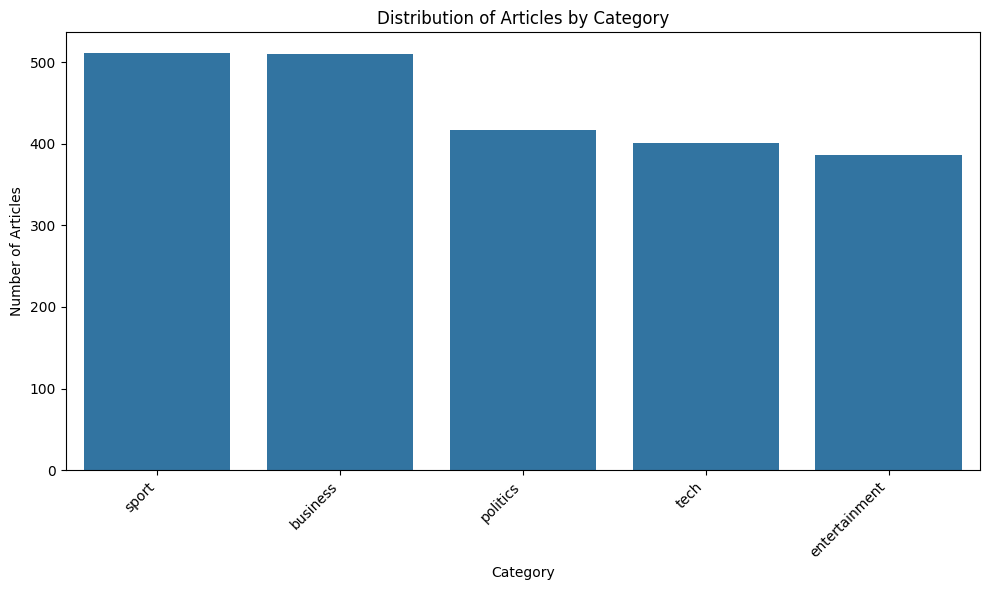

In [9]:
# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribution of Articles by Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocess text

In [10]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


# Apply preprocessing to the article columns
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Display the first few rows of the cleaned articles DataFrame
print(df[['text', 'cleaned_text']].head())

                                                text  \
0  Slow start to speedy net services\n\nFaster br...   
1  Microsoft takes on desktop search\n\nMicrosoft...   
2  Mobile games come of age\n\nThe BBC News websi...   
3  Gadget growth fuels eco concerns\n\nTechnology...   
4  Supercomputer breaks speed record\n\nThe US is...   

                                        cleaned_text  
0  slow start to speedy net services faster broad...  
1  microsoft takes on desktop search microsoft ha...  
2  mobile games come of age the bbc news website ...  
3  gadget growth fuels eco concerns technology fi...  
4  supercomputer breaks speed record the us is po...  


In [11]:
X = df['cleaned_text']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])



In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Sequence Model

In [13]:
max_words = 10000
# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token='<UNK>')
# Fit the tokenizer on the cleaned training reviews
tokenizer.fit_on_texts(X_train)

In [14]:
max_len = 200
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)

In [15]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

In [16]:
X_train_padded

array([[ 278, 3101, 2585, ...,   65, 3103, 6458],
       [   0,    0,    0, ...,  934,    7, 2106],
       [  90,  503,  765, ...,    2,  230, 1469],
       ...,
       [  35,  151,    2, ...,    7,   40,    1],
       [   0,    0,    0, ...,    5, 4438, 7039],
       [1999, 2083, 3128, ..., 1058,   64,   54]], dtype=int32)

In [17]:
y_train

array([0, 3, 1, ..., 4, 3, 1])

In [18]:
def create_lstm_model(max_words, embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
    model.add(LSTM(units=128))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
# Define model parameters
max_words = 10000
embedding_dim = 128
input_length = 100
epochs = 10
batch_size = 64

In [20]:
# Train LSTM model
lstm_model = create_lstm_model(max_words, embedding_dim)
print("Training LSTM model...")
lstm_history = lstm_model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
print(lstm_model.summary())


Training LSTM model...
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 493ms/step - accuracy: 0.2385 - loss: 1.5981 - val_accuracy: 0.4635 - val_loss: 1.4482
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 409ms/step - accuracy: 0.4813 - loss: 1.2313 - val_accuracy: 0.5787 - val_loss: 1.1844
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.6902 - loss: 0.8640 - val_accuracy: 0.5730 - val_loss: 0.9956
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step - accuracy: 0.7828 - loss: 0.7474 - val_accuracy: 0.6770 - val_loss: 0.7266
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 505ms/step - accuracy: 0.8283 - loss: 0.5531 - val_accuracy: 0.8006 - val_loss: 0.6485
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 470ms/step - accuracy: 0.9165 - loss: 0.3311 - val_accuracy: 0.7472 - val_loss: 0.6593
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8760 - loss: 0.3497 - val_accuracy: 0.8230 - val_loss: 0.5466
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step - accuracy: 0.9813 - l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,236,689 (16.16 MB)

 Trainable params: 1,412,229 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,824,460 (10.77 MB)

None


In [21]:
def plot_LSTM(history, model_name):

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


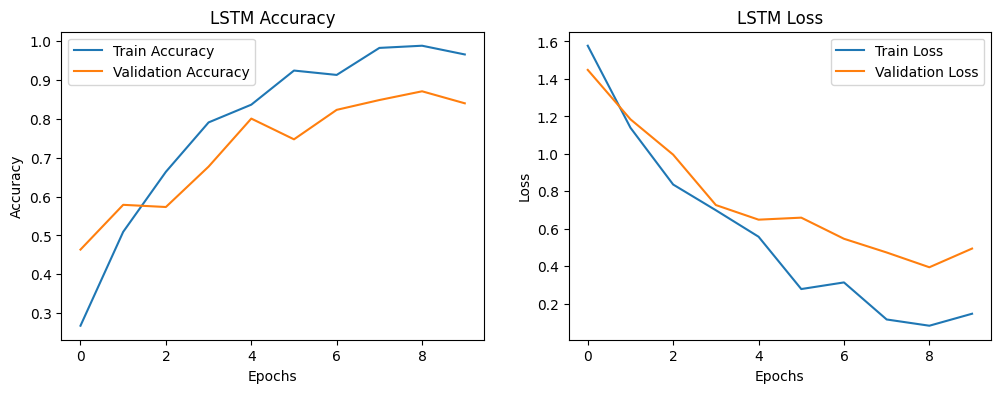

In [22]:
plot_LSTM(lstm_history, 'LSTM')

In [23]:
# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_padded, y_test)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8310 - loss: 0.4937
LSTM Accuracy: 0.8247


In [24]:
def decode_sequence(seq):
    return ' '.join([tokenizer.index_word.get(idx, '') for idx in seq if idx != 0])


y_pred_probs = lstm_model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

pred_sentences = [decode_sequence([pred]) for pred in y_pred]
ref_sentences = [[decode_sequence([ref])] for ref in y_test]

individual_bleus = [sentence_bleu([ref], pred) for ref, pred in zip(ref_sentences, pred_sentences)]

corpus_bleu_score = corpus_bleu(ref_sentences, pred_sentences)

print(f"Average sentence BLEU: {np.mean(individual_bleus):.4f}")
print(f"Corpus BLEU: {corpus_bleu_score:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Average sentence BLEU: 0.0000
Corpus BLEU: 0.4407


# Transformer Upgrade

In [25]:
in_text = keras.Input(shape=(max_len,))

# embedding + average
embedded = Embedding(input_dim=tokenizer.num_words, output_dim=100)(in_text)
averaged = Lambda(lambda x: tf.reduce_mean(x, axis=1))(embedded)

output = Dense(5, activation='softmax', name='category')(averaged)

model = keras.Model(inputs=in_text, outputs=output)

model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['SparseCategoricalAccuracy']
)

In [26]:
model.summary()

history = model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ category (Dense)                │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,505 (3.82 MB)

 Trainable params: 1,000,505 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - SparseCategoricalAccuracy: 0.2744 - loss: 1.5932 - val_SparseCategoricalAccuracy: 0.4354 - val_loss: 1.5350
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - SparseCategoricalAccuracy: 0.5059 - loss: 1.5019 - val_SparseCategoricalAccuracy: 0.4803 - val_loss: 1.4488
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - SparseCategoricalAccuracy: 0.6107 - loss: 1.4018 - val_SparseCategoricalAccuracy: 0.6657 - val_loss: 1.3454
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - SparseCategoricalAccuracy: 0.7537 - loss: 1.2941 - val_SparseCategoricalAccuracy: 0.7837 - val_loss: 1.2178
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - SparseCategoricalAccuracy: 0.8543 - loss: 1.1355 - val_SparseCategoricalAccuracy: 0.8258 - val_loss: 1.0839
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - SparseCategoricalAccuracy: 0.8786 - loss: 0.9938 - val_SparseCategoricalAccuracy: 0.8652 - val_loss: 0.9481
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━

In [27]:
def plot_Transformer(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['SparseCategoricalAccuracy'], label='Train Accuracy')
    plt.plot(history.history['val_SparseCategoricalAccuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

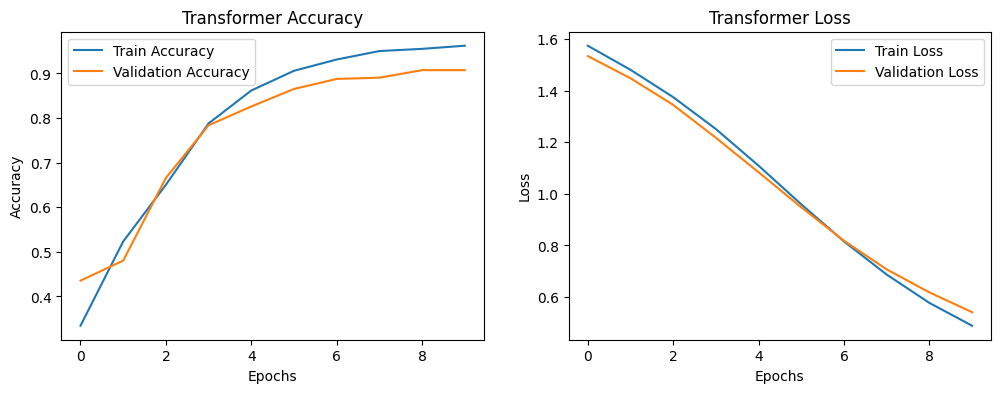

In [28]:
plot_Transformer(history, 'Transformer')

In [29]:
# Evaluate Transformer model
transformer_loss, transformer_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Transformer Accuracy: {transformer_accuracy:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - SparseCategoricalAccuracy: 0.9473 - loss: 0.5346 
Transformer Accuracy: 0.9281


# Compare results
1. transformer has more validation acuurecy.
2. have more prediction acurrecy || LSTM Accuracy: 0.8310 , Transformer Accuracy: 0.9258 ||.
3. But LSTM has less loss values than Transformer || LSTM loss: 0.4937 , Transformer loss: 0.5360 ||.

# Analysis & Reflection

### Limitations of sequence models in your experiment.

1. drawback in long learning models because (LSTM,GRU) don't remember old memoreis due to vanishing and exploding gradients.
2. slow learning because the processes isn't parallel.
3. all senstences must have same length.
--------------------------------------------------------------------------
### Where the Transformer performed better.

1. understand the relations between sentences.
2. quick training because the processes is parallel.
3. more Validation Accuracy.
--------------------------------------------------------------------------
### Where the Transformer performed worse.

1. Needs data more than LSTM.
2. less performance with short sentences.
--------------------------------------------------------------------------
### Possible improvements with more data or model changes.

1. increase LSTM Model accurecy.
2. increase data size.
--------------------------------------------------------------------------